In [1]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import os
import numpy
import pandas
from chromwave import runtime_dataset, filesystem, chromwavenet, vis

Using TensorFlow backend.


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
project_dir = os.path.abspath(os.path.join(os.getcwd(),'../../../'))
working_dir = os.path.join(project_dir, 'ChromWave')
output_dir = os.path.join(project_dir,'Test')


In [4]:
data_dir = os.path.join(working_dir, 'data')
model_dir = os.path.join(working_dir, 'models')

old_profile1=os.path.join(data_dir,'hu2014','GSM1143095_nucleosome_old_rep1.bed')
young_profile1=os.path.join(data_dir,'hu2014','GSM1143089_nucleosome_young_rep1.bed')

model_dir = os.path.join(model_dir,'nucleosomes/sacCer3_old_young')

genome_dir = os.path.join(data_dir,'genomes/sacCer3')

Evaluation and validation data will be generated from the training data with a fractional weighting of: 0.1 and 0.2
Loading genomic data... 
Mitochondrial chromosome will be kept as separate data...
using pre-processing params:
{'discretize_function': 'float_to_int', 'assign_non_covered_bases': 'chrom_mean', 'u': 0.01, 'smooth_signal': False, 'normalise_read_counts': None, 'times_median_coverage_max': 10}


/home/cakiroa/projects/ChromWave_python3/chromwave/functions/signal_processing.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_data_frame.dropna(axis=0, inplace=True)


using pre-processing params:
{'discretize_function': 'float_to_int', 'assign_non_covered_bases': 'chrom_mean', 'u': 0.01, 'smooth_signal': False, 'normalise_read_counts': None, 'times_median_coverage_max': 10}
Binding profiles were binned into [17, 33] bins.
Beginning training data load
Removing 33 fragments that have have too many constant values in all of the provided profiles.
Subsetting training data with test proportion: 0.1 and validation proportion 0.2
Adding reverse complement of genomic sequences and binding profiles for training, test and validation data... 


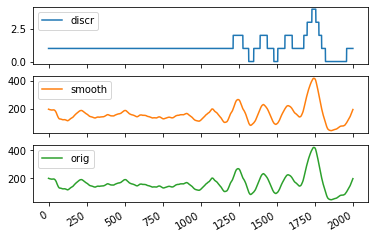

In [5]:
source_profiles = [old_profile1,young_profile1]
f = filesystem.FileSystem(genome_dir ,output_dir,source_profile= source_profiles,overwrite=False, test_fraction = 0.1, val_fraction=0.2,resume = True)
r = runtime_dataset.RuntimeDataset(f)
r._set_seed = None
r._shuffle_sequences = True
r.save_data = False
r._include_rc = True
r.class_weight_cap = [40,40]
r._remove_unmapped_training_regions = 0.7
r.data_format = 'raw_counts'

nuc_preprocessing_params = { 'discretize_function': 'float_to_int',
                            'assign_non_covered_bases': 'chrom_mean', 'u': 0.01, 'smooth_signal': False, 'normalise_read_counts':None,'times_median_coverage_max':10}

r.preprocessing_params = [nuc_preprocessing_params,nuc_preprocessing_params]
r.load_data()

pandas.DataFrame(numpy.vstack((r.train_y_data_discr[0][100],r.train_y_data_smooth[0][100],
                               r.train_y_data_orig[0][100])).transpose(),
                 columns=[ 'discr', 'smooth', 'orig']).plot(subplots=True)
plt.show()

In [6]:
model =  chromwavenet.ChromWaveNet()
model.deserialize(directory = model_dir)

Receptive Field: 1024 


In [7]:
model.preprocessing_params

[{'discretize_function': 'float_to_int',
  'assign_non_covered_bases': 'chrom_mean',
  'u': 0.01,
  'normalise_read_counts': None,
  'times_median_coverage_max': 10,
  'smooth_signal': False},
 {'discretize_function': 'float_to_int',
  'assign_non_covered_bases': 'chrom_mean',
  'u': 0.01,
  'normalise_read_counts': None,
  'times_median_coverage_max': 10,
  'smooth_signal': False}]

We can use the keras functionality to compute the losses, accuracy, mean squared error and Pearson correlation between the predicted and observed profiles of the validation set:

In [8]:
loss_0, loss_1, loss_combined, acc_0, mse_0, pcor_0, acc_1, mse_1, pcor_1 = model._neural_network.evaluate(r.test_x_data, r.test_y_data)

1358/1358 [==============================] - 18s 13ms/step


In [9]:
print('Pcor young: %f',pcor_0)
print('Pcor old: %f',pcor_1)
print('Accuracy young: %f',acc_0)
print('Accuracy old: %f',acc_1)
print('Mean squared error young: %f',mse_0)
print('Mean squared error old: %f',mse_1)

Pcor young: %f 0.3962990641593933
Pcor old: %f 0.43371737003326416
Accuracy young: %f 0.49471795558929443
Accuracy old: %f 0.2470979392528534
Mean squared error young: %f 0.8372092843055725
Mean squared error old: %f 7.116279125213623


In [10]:
print('Pcor young: %f',pcor_0)
print('Pcor old: %f',pcor_1)
print('Accuracy young: %f',acc_0)
print('Accuracy old: %f',acc_1)
print('Mean squared error young: %f',mse_0)
print('Mean squared error old: %f',mse_1)

Pcor young: %f 0.3962990641593933
Pcor old: %f 0.43371737003326416
Accuracy young: %f 0.49471795558929443
Accuracy old: %f 0.2470979392528534
Mean squared error young: %f 0.8372092843055725
Mean squared error old: %f 7.116279125213623


# How do the predictions look like? 

In [11]:
predictions = model.predict_smooth(r.train_x_data)

What's be best and worst examples in terms of the correlations?

In [12]:
from chromwave.functions import utils

idx = [utils.p_cor(t, p).argsort()[::-1] for (t, p) in zip( r.train_y_data_smooth, predictions)]

The profile with the highest correlation between the young profiles:

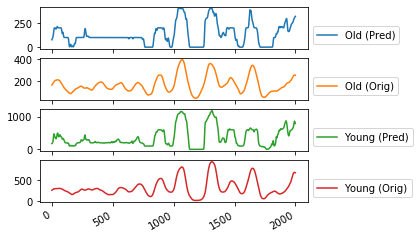

In [13]:
i = idx[0][0]
column_names = ['Old (Pred)', "Old (Orig)"]
column_names.extend(['Young (Pred)', 'Young (Orig)'])
pandas.DataFrame(numpy.vstack(
    (predictions[0][i], r.train_y_data_smooth[0][i],predictions[1][i], r.train_y_data_smooth[1][i])).transpose(),
                 columns=column_names).plot(subplots=True)
for i in range(0,len(plt.gcf().axes)):
    ax =plt.gcf().axes[i]
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc=3, bbox_to_anchor=(1.0, 0.0))
plt.show()

The profiles with the highest correlation between the old profiles: 

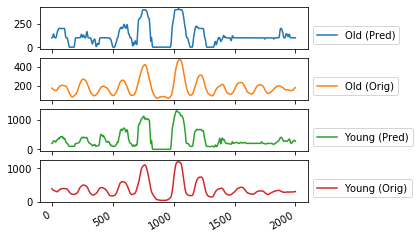

In [14]:
i = idx[1][0]
pandas.DataFrame(numpy.vstack(
    (predictions[0][i], r.train_y_data_smooth[0][i], predictions[1][i], r.train_y_data_smooth[1][i])).transpose(),
                 columns=column_names).plot(subplots=True)
for i in range(0,len(plt.gcf().axes)):
    ax =plt.gcf().axes[i]
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc=3, bbox_to_anchor=(1.0, 0.0))
plt.show()

How do the worst predictions look like? 

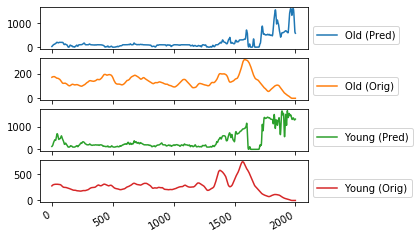

In [15]:
i = idx[0][-1]

pandas.DataFrame(numpy.vstack(
    (predictions[0][i], r.train_y_data_smooth[0][i], predictions[1][i], r.train_y_data_smooth[1][i])).transpose(),
                 columns=column_names).plot(subplots=True)
for i in range(0,len(plt.gcf().axes)):
    ax =plt.gcf().axes[i]
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc=3, bbox_to_anchor=(1.0, 0.0))
plt.show()

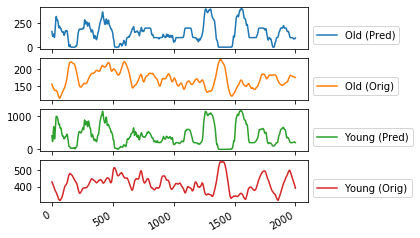

In [16]:
i = idx[1][-1]

pandas.DataFrame(numpy.vstack(
    (predictions[0][i], r.train_y_data_smooth[0][i], predictions[1][i], r.train_y_data_smooth[1][i])).transpose(),
                 columns=column_names).plot(subplots=True)
for i in range(0,len(plt.gcf().axes)):
    ax =plt.gcf().axes[i]
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc=3, bbox_to_anchor=(1.0, 0.0))
plt.show()